Importing libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import  plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from plotly.subplots import make_subplots
from umap import UMAP
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import recall_score, precision_score, f1_score, silhouette_score

Reading files

In [4]:
# Clase contains which type of tissue is each
X = pd.read_csv('datasets/dataset_tissue.txt', index_col = 0).T
y = pd.read_csv('datasets/clase.txt', index_col = 0)

There is no need of using pipelines in this case, so it is scaled the data as first step

In [5]:
X_sc = MinMaxScaler().fit_transform(X)

It has to be known the appropiate number of components which are employed to perform umap algorythm

In [6]:
# declaring and umap instance
svd_all = TruncatedSVD(n_components = X.shape[0], random_state = 23)

# fitting pipeline
svd_all.fit(X_sc)

TruncatedSVD(n_components=189, random_state=23)

Plotting cumulative variance ratio

Number of components: 61


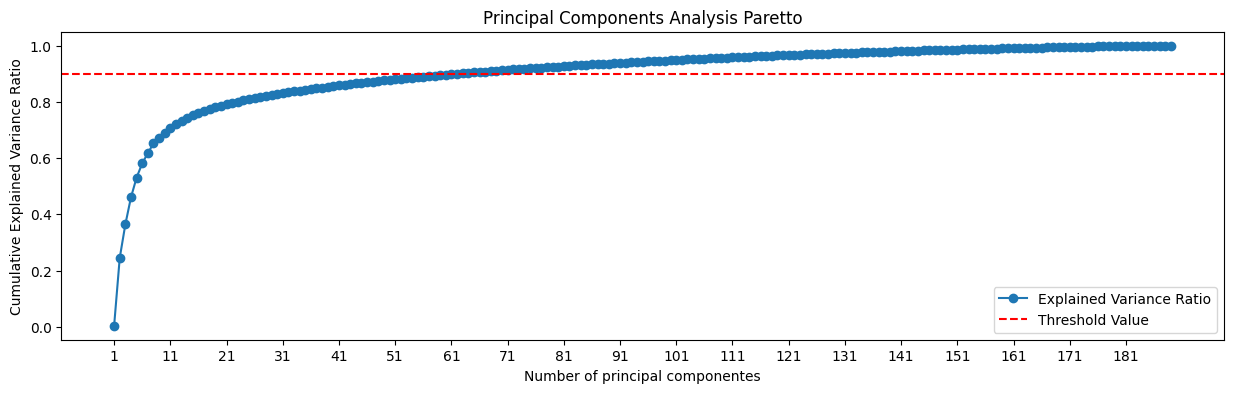

In [49]:
# getting cumulative variance
cum_variance = np.cumsum(svd_all.explained_variance_ratio_)

# choosing threshold
threshold = 0.90

# Calculating the selected number of components by using the chosen threshold
n_svd = len(cum_variance[cum_variance <= threshold])
print(f"Number of components: {n_svd}")

# defining plot
plt.figure(figsize = (15, 4))
plt.plot(cum_variance, '-o', label = 'Explained Variance Ratio')
plt.title('Principal Components Analysis Paretto')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xlabel('Number of principal componentes')
plt.xticks(range(0, X.shape[0], 10), range(1, X.shape[0] + 1, 10))
plt.axhline(threshold, c = 'red', label = 'Threshold Value', linestyle = '--')
plt.legend()
plt.show()


Then the new X dataset is fitted by using the found n_components

In [116]:
# declaring and umap instance
umap = UMAP(n_components = n_svd, init = 'random',  n_neighbors = 4, random_state = 23)

# fitting model
X_umap = umap.fit_transform(X_sc)

c:\Users\b40946\AppData\Local\anaconda3\envs\utec_cs_machine_learning\Lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



Outliers treatment

In [117]:
# function to replace outliers
def clean_outliers(array, col):
    q1 = np.percentile(array[:, col], 25)
    q3 = np.percentile(array[:, col], 75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    array[:, col] = np.select([array[:, col] > upper_bound, array[:, col] < lower_bound],
                              [upper_bound, lower_bound],
                              default = array[:, col])
    return array

length = X_umap.shape[1]
for column in range(length):
    X_umap = clean_outliers(X_umap, column)

Applying Agglomerative Hierarchical Clustering on those selected principal components

In [118]:
# declaring hierarchical clustering instance
agg_clus = AgglomerativeClustering(n_clusters = None, distance_threshold = 0)

# fitting model
agg_clus.fit(X_umap)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

Defining function to plot dendrogram

In [119]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

Plotting dendrogram

Number of Unique Variables of each type: 7


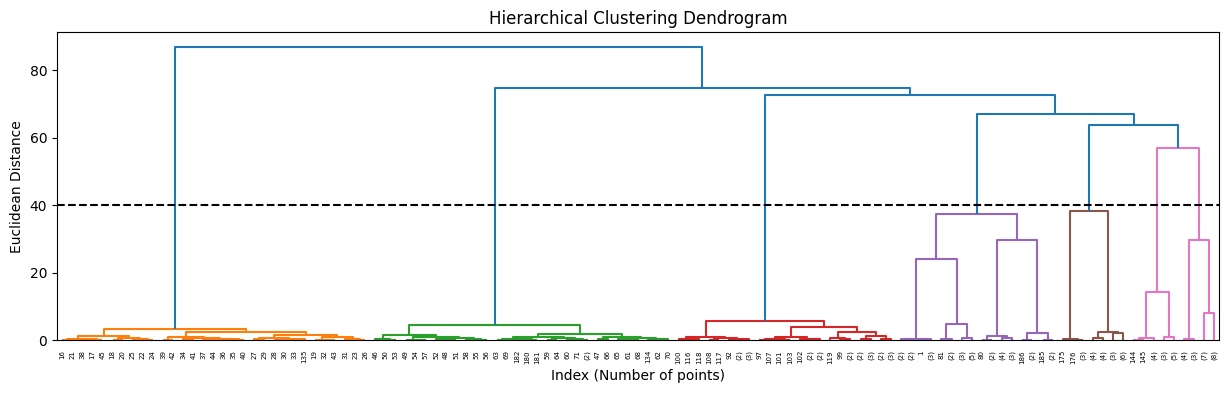

In [120]:
# defining plot
threshold_line_cut = 40
plt.figure(figsize = (15, 4))
top_n_levels_dendrogram = len(np.unique(y))
print(f"Number of Unique Variables of each type: {top_n_levels_dendrogram}")
plot_dendrogram(agg_clus, truncate_mode = 'level', p = top_n_levels_dendrogram)
plt.axhline(threshold_line_cut, c = 'black', linestyle = '--')
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Euclidean Distance')
plt.xlabel('Index (Number of points)')
plt.show()

It can be seen in the previous Figure, by cutting the Hierarchical Dendrogram at 106 Euclidian Distance, it is obtained 7 clusters which corresponds to the number of unique variable of "y" dataset. Now, a kind of elbow plot is made in order to verify these clusters

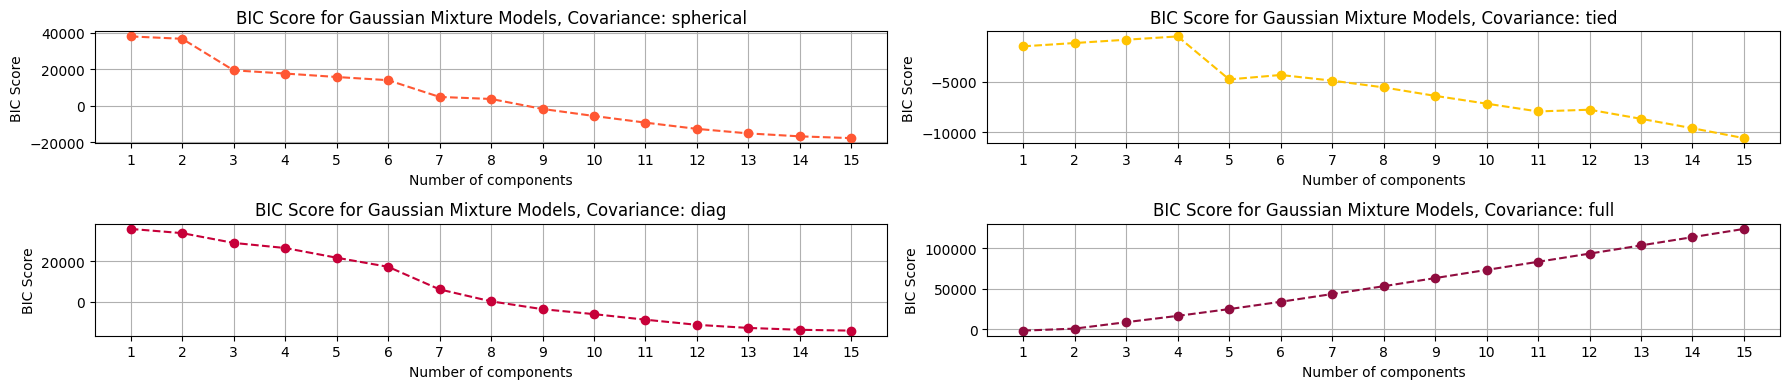

In [121]:
# declaring a dictionary to store bics per covariance type
bic_per_type = dict()

# params to test
n_max_clusters = 15
covariance_types = ['spherical', 'tied', 'diag', 'full']

# iterating the number of clusters in a mixture gaussian instance
for covariance_type in covariance_types:
    # declaring an empty list which stores each inertia per number of clusters
    bic_scores = list()
    for n_clusters in range(1, n_max_clusters + 1):
        # declaring and fitting gaussian mixture model
        gaussian_model = GaussianMixture(n_components = n_clusters, covariance_type = covariance_type, 
                                        init_params = 'k-means++', random_state = 23, reg_covar = 1e-2)
        gaussian_model.fit(X_umap)
        bic_scores.append(gaussian_model.bic(X_umap))
    # storing bic types
    bic_per_type[covariance_type] = bic_scores

# defining positions for covariances types and colors
plots_dict = dict(enumerate(covariance_types))
gauss_colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F"]

# getting the number of components per covariance type which contains the lowest bic
n_components_bic = {key: (min(enumerate(bic_per_type[key]), key = lambda x: x[1])[0] + 1, min(bic_per_type[key]))
                                for key in covariance_types}

# plotting BIC Scores
fig, axis = plt.subplots(2, 2, figsize = (18,4))

for key, data in plots_dict.items():
    row = key // 2
    col = key % 2
    ax = axis[row, col]
    ax.plot(bic_per_type[data], marker = 'o', linestyle = '--', color = gauss_colors[key])
    ax.set_xlabel('Number of components')
    ax.set_xticks(range(0, n_max_clusters), range(1, n_max_clusters + 1))
    ax.set_ylabel('BIC Score')
    ax.set_title(f'BIC Score for Gaussian Mixture Models, Covariance: {data}')
    ax.grid(True)

plt.tight_layout()
plt.show()

Another way to test the n_components performance is by selecting the best silhouette score, the following cells shows the evaluation in terms of it

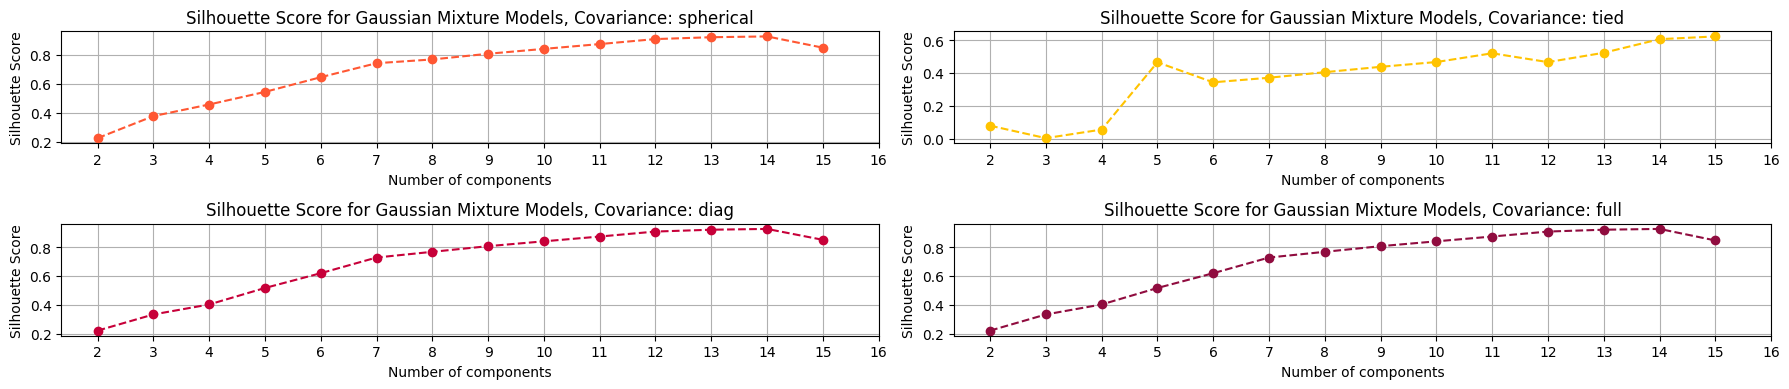

In [122]:
# declaring a dictionary to store bics per covariance type
silhouette_per_type = dict()

# params to test
n_max_clusters = 15
covariance_types = ['spherical', 'tied', 'diag', 'full']

# iterating the number of clusters in a mixture gaussian instance
for covariance_type in covariance_types:
    # declaring an empty list which stores each inertia per number of clusters
    silhouette_scores = list()
    for n_clusters in range(2, n_max_clusters + 1):
        # declaring and fitting gaussian mixture model
        gaussian_model = GaussianMixture(n_components = n_clusters, covariance_type = covariance_type, 
                                        init_params = 'k-means++', random_state = 23, reg_covar = 1e-2)
        gaussian_model.fit(X_umap)
        silhouette_scores.append(silhouette_score(X_umap, gaussian_model.predict(X_umap)))
    # storing bic types
    silhouette_per_type[covariance_type] = silhouette_scores

# defining positions for covariances types and colors
plots_dict = dict(enumerate(covariance_types))
gauss_colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F"]

# getting the number of components per covariance type which contains the highest silhouette score
n_components_sil = {key: (max(enumerate(silhouette_per_type[key]), key = lambda x: x[1])[0] + 2, max(silhouette_per_type[key]))
                                for key in covariance_types}

# plotting BIC Scores
fig, axis = plt.subplots(2, 2, figsize = (18,4))

for key, data in plots_dict.items():
    row = key // 2
    col = key % 2
    ax = axis[row, col]
    ax.plot(silhouette_per_type[data], marker = 'o', linestyle = '--', color = gauss_colors[key])
    ax.set_xlabel('Number of components')
    ax.set_xticks(range(0, n_max_clusters), range(2, n_max_clusters + 2))
    ax.set_ylabel('Silhouette Score')
    ax.set_title(f'Silhouette Score for Gaussian Mixture Models, Covariance: {data}')
    ax.grid(True)

plt.tight_layout()
plt.show()

Showing the lowest BIC and the highest Silhouette score per covariance type and select the minimum , maximum one

In [123]:
bic_summary = pd.DataFrame(n_components_bic).T.rename(columns = {0: 'n_components_bic', 1: 'bic_score'})
sil_summary = pd.DataFrame(n_components_sil).T.rename(columns = {0: 'n_components_sil', 1: 'sil_score'})
result_summary = pd.concat([bic_summary, sil_summary], axis = 1)
display(result_summary)

,n_components_bic,bic_score,n_components_sil,sil_score
spherical,15.0,-17664.787519,14.0,0.926741
tied,15.0,-10562.268683,15.0,0.622673
diag,15.0,-14337.393941,14.0,0.926741
full,1.0,-1524.097511,14.0,0.926741


As it can be observed in the plot, the lowest BIC score corresponds to a 7th-cluster-full-gaussian mixture model and the highest silhoutte to a 9th-cluster-spherical-gaussian one, this makes sense regarding the previous hierarchical plot, which showed below the threshold that there were more divisions that could have been made by decreasing this value. Now, in order to select one of them, it is compared both metrics for both cases, then it is selected one

In [124]:
# declaring selected n_components and covariance types
n_components_list = [int(result_summary.loc[result_summary.bic_score == result_summary.bic_score.min(), 'n_components_bic'][0]),
                     int(result_summary.loc[result_summary.sil_score == result_summary.sil_score.max(), 'n_components_sil'][0])]
covariance_types_list = [result_summary.loc[result_summary.bic_score == result_summary.bic_score.min()].index[0],
                         result_summary.loc[result_summary.sil_score == result_summary.sil_score.max()].index[0]]

# empty dictionary to store bic and silhouette scores
bic_sil_list = list()
# iterating with the same gaussian attributes
for covariance_type, n_components in zip(covariance_types_list, n_components_list):
    # declaring and fitting gaussian mixture model
    gaussian_model = GaussianMixture(n_components = n_components, covariance_type = covariance_type, 
                                    init_params = 'k-means++', random_state = 23, reg_covar = 1e-2)
    # fitting model
    gaussian_model.fit(X_umap)

    # storing metrics
    bic_sil_score = dict()
    bic_sil_score['covariance_type'] = covariance_type
    bic_sil_score['n_components'] = n_components
    bic_sil_score['bic_score'] = gaussian_model.bic(X_umap)
    bic_sil_score['sil_score'] = silhouette_score(X_umap, gaussian_model.predict(X_umap))
    bic_sil_list.append(bic_sil_score)

As it can be seen , $full$ with 7 components has a lower bic_score and a lower sil_score in contrast, and $spherical$ with 9 components has a greater bic_score and a greater sil_score. Thus, both are selected to test the incoming labels

In [125]:
bic_sil_tbl = pd.DataFrame(bic_sil_list)
display(bic_sil_tbl)

,covariance_type,n_components,bic_score,sil_score
0,spherical,15,-17664.787519,0.849033
1,spherical,14,-16687.566972,0.926741


Fitting both models to finally evaluate them 

In [126]:
# declaring selected n_components and covariance types
n_components_list = [int(result_summary.loc[result_summary.bic_score == result_summary.bic_score.min(), 'n_components_bic'][0]),
                     int(result_summary.loc[result_summary.sil_score == result_summary.sil_score.max(), 'n_components_sil'][0])]
covariance_types_list = [result_summary.loc[result_summary.bic_score == result_summary.bic_score.min()].index[0],
                         result_summary.loc[result_summary.sil_score == result_summary.sil_score.max()].index[0]]

# store both models in a list
gaussian_models = list()

# iterating across components
for covariance_type, n_components in zip(covariance_types_list, n_components_list):
    # declaring and fitting gaussian mixture model
    gaussian_model = GaussianMixture(n_components = n_components, covariance_type = covariance_type, 
                                    init_params = 'k-means++', random_state = 23, reg_covar = 1e-2)
    # fitting model
    gaussian_model.fit(X_umap)

    # storing model
    gaussian_models.append(gaussian_model)

Now it has been fitted, predictions need to be performed to get the labels the model has grouped

In [127]:
# getting labels
gaussian_labels = [gaussian_model.predict(X_umap).astype(int) for gaussian_model in gaussian_models]

In order to visualize how clusters were corresponded, another umap fit is done but this time only with 2 components to have x-y axis

In [128]:
# Declaring umap instance to use for plotting
svd_plot = UMAP(n_components=3, random_state=23)

# Creating the X_plot dataset
X_plot = svd_plot.fit_transform(X_sc)

# Plotting with Plotly
colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
          "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC"]

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

for j in range(2):
    model = gaussian_models[j]
    X_plot_gauss = np.c_[X_plot, gaussian_labels[j]]
    n_components = len(np.unique(gaussian_labels[j]))
    
    for category in np.unique(gaussian_labels[j]):
        category_indices = (gaussian_labels[j] == category)
        scatter = go.Scatter3d(x=X_plot_gauss[category_indices, 0], 
                               y=X_plot_gauss[category_indices, 1], 
                               z=X_plot_gauss[category_indices, 2],
                               mode='markers', 
                               marker=dict(color=colors[category], size=5),
                               name=f'Category {category}',
                               legendgroup=f'Category {category}')

        fig.add_trace(scatter, row=1, col=j + 1)

titles = [f'n = {gaussian_models[0].n_components}, covariance = {gaussian_models[0].covariance_type}',
          f'n = {gaussian_models[1].n_components}, covariance = {gaussian_models[1].covariance_type}']

legend_1 = go.layout.Annotation(x=0.5, y=1.15, xref="paper", yref="paper", text=titles[0], showarrow=False, font=dict(size=15))
legend_2 = go.layout.Annotation(x=1.5, y=1.15, xref="paper", yref="paper", text=titles[1], showarrow=False, font=dict(size=15))

# Configure the layout of the plot
fig.update_layout(scene1=dict(xaxis_title='Component 1', yaxis_title='Component 2', zaxis_title='Component 3'),
                  scene2=dict(xaxis_title='Component 1', yaxis_title='Component 2', zaxis_title='Component 3'),
                  width=1500,
                  height=700,
                  annotations=[
                      dict(
                          showarrow=False,
                          text=titles[0],
                          xref='paper', yref='paper',
                          x=0, y=1.05,
                          font=dict(size=15)
                      ),
                      dict(
                          showarrow=False,
                          text=titles[1],
                          xref='paper', yref='paper',
                          x=0.5, y=1.05,
                          font=dict(size=15)
                      )
                  ])

fig.show()


c:\Users\b40946\AppData\Local\anaconda3\envs\utec_cs_machine_learning\Lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



Then it is compared to the actual "y" targets, as first step, a encoding transformation has to be performed before the comparison

In [129]:
# changing unique values for numeric ones
y_label = np.zeros((len(y), 1))
target_dict = dict()
for label, tissue_type in enumerate(np.unique(y)):
    y_label = np.where(y == tissue_type, label, y_label)
    target_dict[label] = tissue_type

y_label = y_label.ravel().astype(int)

# Creating the X_plot dataset for the third subplot
X_plot_real = np.c_[X_plot, y_label]

colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
          "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC"]

fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# first two subplots
for j in range(2):
    model = gaussian_models[j]
    X_plot_gauss = np.c_[X_plot, gaussian_labels[j]]
    n_components = len(np.unique(gaussian_labels[j]))
    
    for category in np.unique(gaussian_labels[j]):
        category_indices = (gaussian_labels[j] == category)
        scatter = go.Scatter3d(x=X_plot_gauss[category_indices, 0], 
                               y=X_plot_gauss[category_indices, 1], 
                               z=X_plot_gauss[category_indices, 2],
                               mode='markers', 
                               marker=dict(color=colors[category], size=5),
                               name=f'Category {category}',
                               legendgroup=f'Category {category}')

        fig.add_trace(scatter, row=1, col=j + 1)

# third subplot
for category in np.unique(y_label):
    category_indices = (y_label == category)
    scatter = go.Scatter3d(x=X_plot_real[category_indices, 0], 
                           y=X_plot_real[category_indices, 1], 
                           z=X_plot_real[category_indices, 2],
                           mode='markers', 
                           marker=dict(color=colors[category], size=5),
                           name=f'Category {category}',
                           legendgroup=f'Category {category}')

    fig.add_trace(scatter, row=1, col=3)

titles = [f'n = {gaussian_models[0].n_components}, covariance = {gaussian_models[0].covariance_type}',
          f'n = {gaussian_models[1].n_components}, covariance = {gaussian_models[1].covariance_type}',
          'umap plot using Actual labels']

# Configure the layout of the plot
fig.update_layout(scene1=dict(xaxis_title='Component 1', yaxis_title='Component 2', zaxis_title='Component 3'),
                  scene2=dict(xaxis_title='Component 1', yaxis_title='Component 2', zaxis_title='Component 3'),
                  scene3=dict(xaxis_title='Component 1', yaxis_title='Component 2', zaxis_title='Component 3'),
                  width=1800,
                  height=700,
                  annotations=[
                      dict(
                          showarrow=False,
                          text=titles[0],
                          xref='paper', yref='paper',
                          x=0, y=1.05,
                          font=dict(size=15)
                      ),
                      dict(
                          showarrow=False,
                          text=titles[1],
                          xref='paper', yref='paper',
                          x=0.5, y=1.05,
                          font=dict(size=15)
                      ),
                      dict(
                          showarrow=False,
                          text=titles[2],
                          xref='paper', yref='paper',
                          x=1, y=1.05,
                          font=dict(size=15)
                      )
                  ])

fig.show()


By looking at the plots, it can be appreciated some differences, and, based on the fact that class numbers have nothing to do with the gaussian labels inasmuch as the second ones were assigned during the fitting process without having actual labels information. Thus, a check cluster task is performed to visualize the most frequent actual label in each gaussian cluster

In [130]:
# Declaring umap instance to use for plotting
svd_plot = UMAP(n_components=3, random_state=23)

# Creating the X_plot dataset
X_plot = svd_plot.fit_transform(X_sc)

# Plotting with Plotly
colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
          "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC"]

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

bases = pd.DataFrame()

for j in range(2):
    model = gaussian_models[j]
    X_plot_gauss = np.c_[X_plot, gaussian_labels[j]]
    
    # Creating a dataframe with gaussian clusters and actual labels
    base_information = {'gaussian_labels': gaussian_labels[j],
                        'actual_labels': y_label,
                        'label_name': y.to_numpy().ravel()}
    
    data_clusters = pd.DataFrame(base_information)
    
    # querying dataframe to verify most frequent label name per gaussian label
    gaussian_dict = data_clusters.groupby('gaussian_labels').agg({'label_name': lambda x: x.mode().iloc[0]}).to_dict()['label_name']
    data_clusters['predicted_label_name'] = data_clusters['gaussian_labels'].map(gaussian_dict) # predictions
    data_clusters['n_components'] = model.n_components
    data_clusters['covariance_type'] = model.covariance_type
    n_unique_predicted = len(np.unique(data_clusters['predicted_label_name']))

    # store in big dataframe
    bases = pd.concat([bases, data_clusters], axis=0, ignore_index=True)
    
    # Create 3D scatter plot
    for col_index, category in enumerate(np.unique(data_clusters['predicted_label_name'])):
        category_indices = (data_clusters['predicted_label_name'] == category)
        scatter = go.Scatter3d(x=X_plot_gauss[category_indices, 0], y=X_plot_gauss[category_indices, 1], z=X_plot_gauss[category_indices, 2],
                            mode='markers', marker=dict(color=colors[col_index], 
                                                            colorscale='Viridis', size=5),
                           name=f'Category {category}',
                           legendgroup=f'Category {category}')

        fig.add_trace(scatter, row=1, col=j + 1)

titles = [f'n = {gaussian_models[0].n_components}, covariance = {gaussian_models[0].covariance_type}',
          f'n = {gaussian_models[1].n_components}, covariance = {gaussian_models[1].covariance_type}']

# Configure the layout of the plot
fig.update_layout(scene1=dict(xaxis_title='Component 1', yaxis_title='Component 2', zaxis_title='Component 3'),
                  scene2=dict(xaxis_title='Component 1', yaxis_title='Component 2', zaxis_title='Component 3'),
                  width=1500,
                  height=700,
                  annotations=[
                      dict(
                          showarrow=False,
                          text=titles[0],
                          xref='paper', yref='paper',
                          x=0, y=1.05,
                          font=dict(size=15)
                      ),
                      dict(
                          showarrow=False,
                          text=titles[1],
                          xref='paper', yref='paper',
                          x=0.5, y=1.05,
                          font=dict(size=15)
                      )
                  ])

fig.show()


c:\Users\b40946\AppData\Local\anaconda3\envs\utec_cs_machine_learning\Lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



As it can be seen, gaussian models cannot predict the placenta target by having as a prediction the most frequent class at each gaussian component, afterall, there are other methods to be performed. Now it is time to evaluate recall, precision and f1 score using macro average.

In [131]:
for covariance_type, n_components in zip(covariance_types_list, n_components_list):
    base_filter = bases.loc[(bases.covariance_type == covariance_type) & (bases.n_components == n_components)]
    # getting actual values and predictions
    y_actual = base_filter.label_name
    y_pred = base_filter.predicted_label_name

    # getting scores
    recall_gauss = recall_score(y_actual, y_pred, average = 'macro', zero_division = 0)
    precision_gauss = precision_score(y_actual, y_pred, average = 'macro', zero_division = 0)
    f1_gauss = f1_score(y_actual, y_pred, average = 'macro', zero_division = 0)

    # Showing metrics
    print(f'Model: covariance_type = {covariance_type} and n_components = {n_components}')
    print(f"Recall score: {recall_gauss:.4f}")
    print(f"Precision score: {precision_gauss:.4f}")
    print(f"F1 score: {f1_gauss:.4f}\n")

Model: covariance_type = spherical and n_components = 15
Recall score: 0.9817
Precision score: 0.9864
F1 score: 0.9834

Model: covariance_type = spherical and n_components = 14
Recall score: 0.9817
Precision score: 0.9864
F1 score: 0.9834



In conclusion, from the evaluated models, the one that has the best performance in terms of the predicted labels is the second one, with 9 components and $spherical$ as covariance type